## Synchrotron and Synchrotron Self Compton Tutorial
In this tutorial we will show how to compute the Spectral Energy Distribution produced by the Synchrotron and Synchrotron Self-Compton radiative processes in a jetted AGN.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import Distance
import matplotlib.pyplot as plt

In [2]:
# import agnpy classes
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton

In [3]:
# matplotlib adjustments and axes labels
plt.rc("figure", figsize=(7.5, 5.5))
plt.rc("font", size=12)
plt.rc("axes", grid=True)
plt.rc("grid", ls=":")
sed_x_label = r"$\nu\,/\,Hz$"
sed_y_label = r"$\nu F_{\nu}\,/\,(\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1})$"

### emission region
Let us consider that the emission region is a spherical plasmoid of radius $R_b = 10^{16}\,\mathrm{cm}$, streaming with Lorentz factor $\Gamma=10$ in the AGN jet, resulting in a Doppler boosting of $\delta_D=10$ (the jet is almost aligned with the observer's line of sight). The galaxy hosting the active nucleus is at a distance of $d_L=10^{27}\,\mathrm{cm}$. The blob has a tangled magnetic field $B=1\,\mathrm{G}$. The electron spectrum is described by a power law with index $-2.8$ and a total energy content of $W_e = 10^{48}\,{\rm erg}$.

In [4]:
spectrum_norm = 1e48 * u.Unit("erg") 
spectrum_dict = {
    "type": "PowerLaw", 
    "parameters": {
        "p": 2.8, 
        "gamma_min": 1e2, 
        "gamma_max": 1e7
    }
}
R_b = 1e16 * u.cm
B = 1 * u.G
z = Distance(1e27, unit=u.cm).z
delta_D = 10
Gamma = 10
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)

In [5]:
# the blob object is printable, returning a summary of its properties
print(blob)

* spherical emission region
 - R_b (radius of the blob): 1.00e+16 cm
 - V_b (volume of the blob): 4.19e+48 cm3
 - z (source redshift): 0.07
 - d_L (source luminosity distance):1.00e+27 cm
 - delta_D (blob Doppler factor): 1.00e+01
 - Gamma (blob Lorentz factor): 1.00e+01
 - Beta (blob relativistic velocity): 9.95e-01
 - theta_s (jet viewing angle): 5.74e+00 deg
 - B (magnetic field tangled to the jet): 1.00e+00 G
* electron spectrum
 - power law
 - k_e: 9.29e+06 1 / cm3
 - p: 2.80
 - gamma_min: 1.00e+02
 - gamma_max: 1.00e+07



In [6]:
# we can also print the total electrons number and energy
print(f"total particle number: {blob.N_e_tot:.2e}")
print(f"total energy in electrons: {blob.W_e:.2e}")

total particle number: 5.45e+51
total energy in electrons: 1.00e+48 erg


In [7]:
# as well as the jet power in particles and magnetic fields (see the documentation for more details)
print(f"jet power in particles: {blob.P_jet_e:.2e}")
print(f"jet power in magnetic field: {blob.P_jet_B:.2e}")

jet power in particles: 4.48e+44 erg / s
jet power in magnetic field: 7.46e+43 erg / s


### synchrotron radiation
To intitialise the object that will compute the synchrotron radiation, we simply pass the `Blob` instance to the `Synchrotron` class. The synchrotron self absorption can be considered when computing the SED.

In [8]:
synch = Synchrotron(blob)
synch_ssa = Synchrotron(blob, ssa=True)

In [9]:
# let us define now a grid of frequencies over which to calculate the synchrotron SED
nu_syn = np.logspace(8, 23) * u.Hz
# let us compute a synchrotron, and a self-absorbed synchrotron SED
synch_sed = synch.sed_flux(nu_syn)
synch_sed_ssa = synch_ssa.sed_flux(nu_syn) 

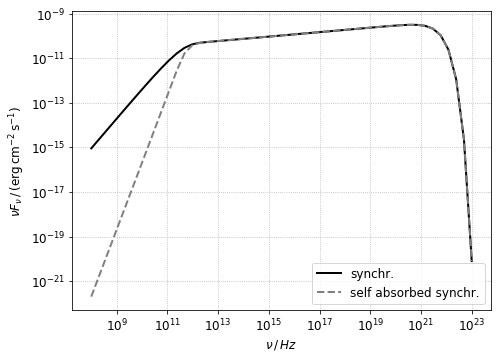

In [10]:
plt.loglog(nu_syn, synch_sed, color="k", lw=2, label="synchr.")
plt.loglog(nu_syn, synch_sed_ssa, lw=2, ls="--", color="gray", label="self absorbed synchr.")
plt.xlabel(sed_x_label)
plt.ylabel(sed_y_label)
plt.legend()
plt.show()

### synchrotron self-Compoton radiation
Similarly to the synchrotron case, to intitialise the object that will compute the synchrotron self-Compton (SSC) radiation, we simply pass the `Blob` and the `Synchrotron` instances to the `SynchrotronSelfCompton` class.       
We examine also the case produced by scattering over a self-absorbed synchrotron spectrum.

In [11]:
# simple ssc
ssc = SynchrotronSelfCompton(blob, synch)
# ssc over a self-absorbed synchrotron spectrum
ssc_ssa = SynchrotronSelfCompton(blob, synch_ssa)

/Users/cosimo/work/agnpy/agnpy/synchrotron.py:95: RuntimeWarning: divide by zero encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/Users/cosimo/work/agnpy/agnpy/synchrotron.py:95: RuntimeWarning: invalid value encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)


In [12]:
nu_ssc = np.logspace(15, 30) * u.Hz
sed_ssc = ssc.sed_flux(nu_ssc)
sed_ssc_ssa = ssc_ssa.sed_flux(nu_ssc)

/Users/cosimo/software/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


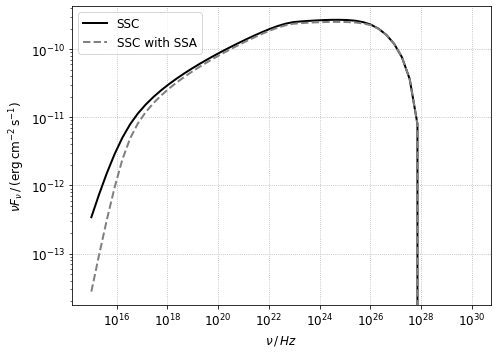

In [13]:
plt.loglog(nu_ssc, sed_ssc, lw=2, color="k", label="SSC")
plt.loglog(nu_ssc, sed_ssc_ssa, lw=2, ls="--", color="gray", label="SSC with SSA")
plt.xlabel(sed_x_label)
plt.ylabel(sed_y_label)
plt.legend()
plt.show()

### reproduce Figure 7.4 of Dermer and Menon (2009)
In order to provide a cross-check with the literature, we reproduce Figure 7.4 of Dermer and Menon (2009) - [see bibliography in the docs](https://agnpy.readthedocs.io/en/latest/bibliography.html). The figure, reported here, depicts two complete synchrotron and SSC SEDs, generated by the same emission regions distinguished only by the different maximum Lorentz factor of their electron distributions ($\gamma_{\rm max} = 10^5$ and $\gamma_{\rm max} = 10^7$). 

![](figures/figure_7_4_dermer_2009.png)

The `Blob` previosuly defined is already set with the parameters reproducing the example with $\gamma_{\rm max} = 10^7$, let us create a new `Blob` containing an electron distribution with $\gamma_{\rm max} = 10^5$.

In [14]:
spectrum_dict["parameters"]["gamma_max"] = 1e5
blob2 = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)
synch2 = Synchrotron(blob2)
ssc2 = SynchrotronSelfCompton(blob2, synch2)

/Users/cosimo/software/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cosimo/software/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


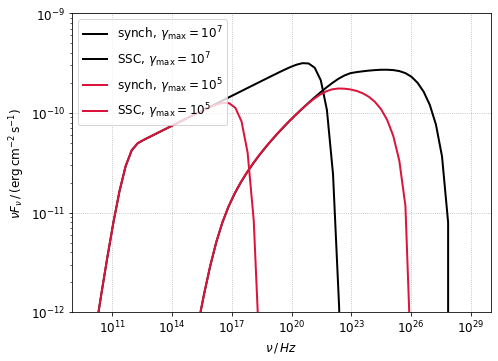

In [15]:
plt.loglog(nu_syn, synch.sed_flux(nu_syn), lw=2, color="k", label=r"${\rm synch},\,\gamma_{\rm max}=10^7$")
plt.loglog(nu_ssc, ssc.sed_flux(nu_ssc), lw=2, color="k", label=r"${\rm SSC},\,\gamma_{\rm max}=10^7$")
plt.loglog(nu_syn, synch2.sed_flux(nu_syn), lw=2, color="crimson", label=r"${\rm synch},\,\gamma_{\rm max}=10^5$")
plt.loglog(nu_ssc, ssc2.sed_flux(nu_ssc), lw=2, color="crimson", label=r"${\rm SSC},\,\gamma_{\rm max}=10^5$")
plt.xlabel(sed_x_label)
plt.ylabel(sed_y_label)
plt.xlim([1e9, 1e30])
plt.ylim([1e-12, 1e-9])
plt.legend(loc=2)
plt.show()